# EDA and data preparation
This file includes the following parts: 
- Choose what subreddits will be used for our analysis (we have chosen 2 so that we can spend more time on detailed analysis of the data).
- Create the appropriate dataset by combining the data from the desired subreddits of interest.
- Start EDA on the dataset of interest and observe any possible trends/relations/clues.
- Summarize the findings and recommendations to be used for the modeling part.
- Repeat the same process in case other subreddits are intended to be investigated.

In [1]:

# imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import os # to check for file existance

# for time conversion
from datetime import datetime
import re   # for regex
# for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

## 'offmychest' and 'relationship_advice' subreddits
In this section, we have investigated two subreddits and tried to see if we can observe any interesting points by doing EDA. The two subreddits of interest are r/offmychest and r/relationship_advice. Both subreddits have a relatively high number of listings per day so this will give us enough information to investigate on. offmychest subreddit mostly contains listings about personal issues, emotional hardships, life problems, and also issues in peoples relationships. The subreddit usually does have a sad tone because people use it as a way to express their feelings, unburden some thoughts, or to confess about things. relationship_advice subreddit focuses more on relationships and the ups and downs in it. <br>
The reasons these two subreddits were used for our investigation is that while these two subreddits represent two topics that could be distinguishable from each other, they do have common points that could make the classification process challenging. Although offmychest includes a wide variety of subjects, it often includes topics which are related to relationship and the problems around it. This overlap can cause our model to struggle since we are mainly relying on the words that used in each listing and having a similar context in both subreddits results in the use of similar vocabularies. 


### Combining data from different subreddits if needed

Read the raw data from the two related csv files. Then combine them together, shuffle, and create  a new csv file. Only create the new csv file if there is not already a .csv file. This makes sure that the current data will not be accidentally overwritten. If the user wants to use new raw .csv files from new data scraping, they will have to delete offmychest-relationship_advice.csv file.

In [2]:
# created the necessary file if not already created by mixing two related data
subred1 = 'offmychest'
subred2 = 'relationship_advice'
path = './../dataset/'

if not os.path.isfile(path+subred1+subred2+'.csv'):

    df1 = pd.read_csv(path+subred1+'.csv')
    df1['subreddit'] = subred1
    df2 = pd.read_csv(path+subred2+'.csv')
    df2['subreddit'] = subred2
    df = pd.concat([df1, df2], axis=0)
    df = df.sample(frac=1)  # shuffle the rows
    print(f'===> creating a new .csv file by merging and shuffling data from {subred1}.csv and {subred2}.csv')
    df.to_csv(path+subred1+subred2+'.csv', index=False)
else:
    print(f'+++> no new file is generated for these data as {subred1+subred2}.csv file already exists')


+++> no new file is generated for these data as offmychestrelationship_advice.csv file already exists


In this dataset, the columns represent the followings:
- 'text': shows the body text of the listing (listing in this document means the reddit post)
- 'title': shows the title of the listing
- 'listingid': shows the unique id of that listing
- 'created': time (utc) for when the listing is created
- 'url': the url related to that listing
- 'media': media related to the listing
- 'subreddit': the name of the subreddit the listing belongs to

In [3]:
# read data from the .csv file
df = pd.read_csv('./../dataset/offmychestrelationship_advice.csv')
df.head(5)

,text,title,listingid,created,url,media,subreddit
0,Sometimes I’m like oh wow can’t wait to marry ...,I am so up and down about my relationship.,18st4x1,1.703768e+09,https://www.reddit.com/r/offmychest/comments/1...,NaN,offmychest
1,\nMy girlfriend is bisexual. While I don’t hav...,My(21M) girlfriend(22F) is Bi and expect diffe...,18ng77o,1.703139e+09,https://www.reddit.com/r/relationship_advice/c...,NaN,relationship_advice
2,My girlfriend and I have been together for ove...,Struggling with My (F34) Partner's Coldness to...,18nmnoa,1.703164e+09,https://www.reddit.com/r/relationship_advice/c...,NaN,relationship_advice
3,I’m able to go home for Christmas which I’m su...,I’m going to be alone on New Year’s yet again,18prukn,1.703410e+09,https://www.reddit.com/r/offmychest/comments/1...,NaN,offmychest
4,I can’t decide if I want to breakup\n\nBasical...,I (f21) and my partner (m23) are struggling em...,18rjesb,1.703628e+09,https://www.reddit.com/r/relationship_advice/c...,NaN,relationship_advice


This cell shows us the total number of listings we have scraped to do our analysis. 

In [4]:
df.shape

(16261, 7)

In [5]:
print('offmychest: ', sum(df['subreddit'] == 'offmychest'))
print('relationship_advice:', sum(df['subreddit'] == 'relationship_advice'))

offmychest:  7120
relationship_advice: 9141


In [6]:
df.isna().sum()

text             0
title            0
listingid        0
created          0
url              0
media        16261
subreddit        0
dtype: int64

In [7]:
# let us drop the media column
df = df.drop(columns=['media'])

### Extract and analyze listing time

The 'created' column in our dataset shows shows the time that listing is created. Let us see if there is a relationship between the time and the subreddit. 

In [8]:
# convert the created number (in Unix time) to the hour of the day (0-24) and weekday (0-6)
# create two additional columns for it.
# find the posting hour
df['posting_hr'] = df['created'].apply(lambda x: datetime.utcfromtimestamp(x).hour)
# find the posting day (day of the week)
df['posting_day'] = df['created'].apply(lambda x: datetime.utcfromtimestamp(x).weekday())
df.head(1)

,text,title,listingid,created,url,subreddit,posting_hr,posting_day
0,Sometimes I’m like oh wow can’t wait to marry ...,I am so up and down about my relationship.,18st4x1,1.703768e+09,https://www.reddit.com/r/offmychest/comments/1...,offmychest,12,3


In [9]:
data = df[df['subreddit'] == 'offmychest']
data.groupby('posting_hr')['created'].count().index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='posting_hr')

In [10]:
data.groupby('posting_hr')['created'].count().values

array([369, 353, 347, 332, 322, 317, 330, 274, 243, 230, 201, 203, 184,
       203, 235, 271, 287, 341, 344, 338, 312, 353, 344, 387], dtype=int64)

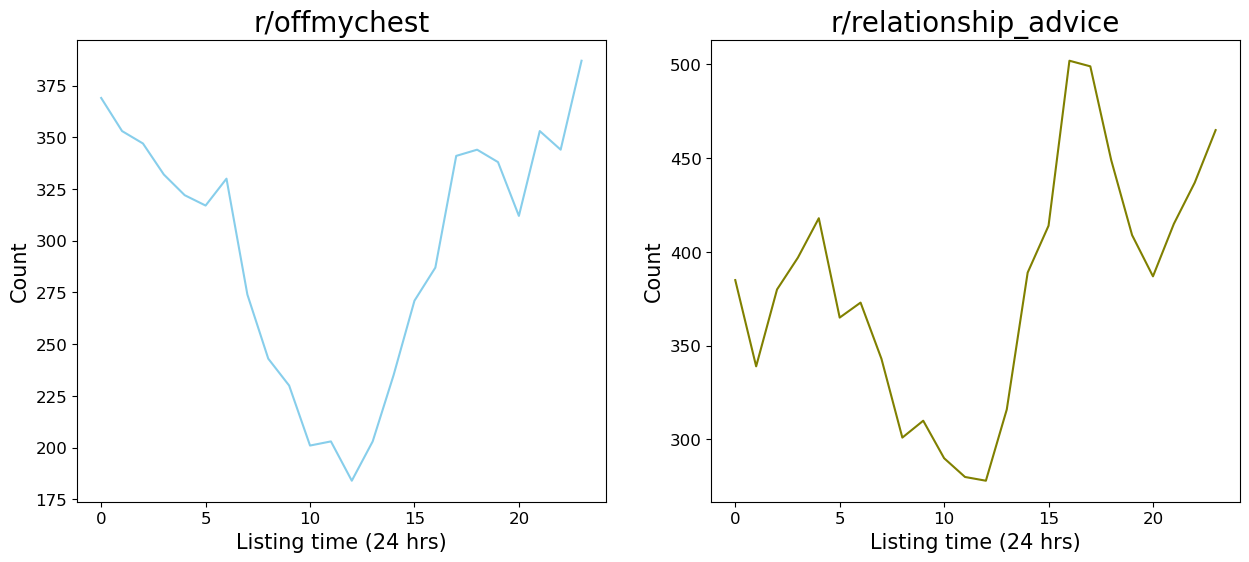

In [11]:
# let us plot the value counts for the hour of the day at which each posting is posted
#plt.figure(figsize=(8,8))
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

data = df[df['subreddit'] == 'offmychest']
x = data.groupby('posting_hr')['created'].count().index
y = data.groupby('posting_hr')['created'].count().values
# plot 1
sns.lineplot(x = x, y =y, color='skyblue', ax=ax[0])
ax[0].set_title('r/offmychest', size=20)
ax[0].set_xlabel("Listing time (24 hrs)", fontsize=15)
ax[0].set_ylabel("Count", fontsize=15)


data = df[df['subreddit'] == 'relationship_advice']
x = data.groupby('posting_hr')['created'].count().index
y = data.groupby('posting_hr')['created'].count().values
# plot 2
sns.lineplot(x=x, y=y, color='olive', ax=ax[1])
ax[1].set_title('r/relationship_advice', size=20)
ax[1].set_xlabel("Listing time (24 hrs)", fontsize=15)
ax[1].set_ylabel("Count", fontsize=15)

for ax in ax:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

#plt.tight_layout()

Looking at the overall trend of the number of listing vs listing time, we can say both of the subreddits follow a similar trend and there is not much to separate them here. Also, it should be noted that this data is been collected in a span of 10 days and such a short time will not be the best representative of the time. For the same reason, we did not use the day of the week data we extracted from the columns. 

### Count the number of words

In [12]:
# create new columns with the number of words in text and titles
df['count_text'] = df['text'].apply(lambda x: len(re.findall(r'(?u)\b\w\w+\b', x)))
df['count_title'] = df['title'].apply(lambda x: len(re.findall(r'(?u)\b\w\w+\b', x)))
df.head(5)

,text,title,listingid,created,url,subreddit,posting_hr,posting_day,count_text,count_title
0,Sometimes I’m like oh wow can’t wait to marry ...,I am so up and down about my relationship.,18st4x1,1.703768e+09,https://www.reddit.com/r/offmychest/comments/1...,offmychest,12,3,104,8
1,\nMy girlfriend is bisexual. While I don’t hav...,My(21M) girlfriend(22F) is Bi and expect diffe...,18ng77o,1.703139e+09,https://www.reddit.com/r/relationship_advice/c...,relationship_advice,6,3,611,10
2,My girlfriend and I have been together for ove...,Struggling with My (F34) Partner's Coldness to...,18nmnoa,1.703164e+09,https://www.reddit.com/r/relationship_advice/c...,relationship_advice,13,3,152,19
3,I’m able to go home for Christmas which I’m su...,I’m going to be alone on New Year’s yet again,18prukn,1.703410e+09,https://www.reddit.com/r/offmychest/comments/1...,offmychest,9,6,110,9
4,I can’t decide if I want to breakup\n\nBasical...,I (f21) and my partner (m23) are struggling em...,18rjesb,1.703628e+09,https://www.reddit.com/r/relationship_advice/c...,relationship_advice,21,1,219,8


In [13]:
# average number of words in text and title for different categories
df.groupby('subreddit').mean()[['count_text', 'count_title']]

C:\Users\masou\AppData\Local\Temp\ipykernel_11760\2696699415.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('subreddit').mean()[['count_text', 'count_title']]


,count_text,count_title
subreddit,,
offmychest,287.083848,8.202247
relationship_advice,400.590417,14.196149


In [14]:
#df[['count_text', 'count_title']].describe()
df.groupby(['subreddit'], as_index=False).agg({'count_text':['min', 'max','mean'],'count_title':['min', 'max','mean']})

subreddit count_text                   count_title               
                              min   max        mean         min max       mean
0           offmychest          0  6103  287.083848           1  53   8.202247
1  relationship_advice          0  6205  400.590417           2  62  14.196149

As we can see, the number of words in the body of text and also the title for the relationship_advice subreddit is almost 30% larger than that of the offmychest subreddit. The same trend is observed for the title count. Now, let us plot distribution of the number of words for each of the subreddits. 

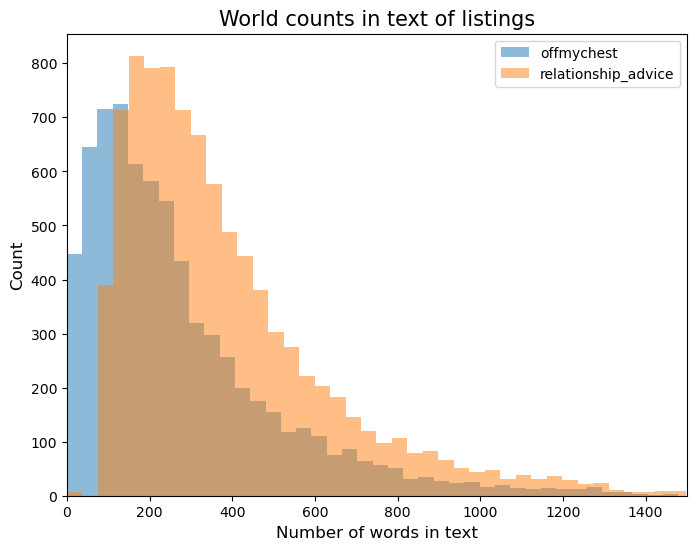

In [29]:
plt.figure(figsize=(8, 6))
data = df[df['count_text'] <=1500]
plt.hist(data[data['subreddit'].str.contains('offmychest')]['count_text'], bins=40, alpha=0.5, label='offmychest')
plt.hist(data[data['subreddit'].str.contains('relationship_advice')]['count_text'], bins=40, alpha=0.5, label='relationship_advice')
plt.legend()
plt.xlabel('Number of words in text', fontsize = 12)
plt.xlim(0, 1500)
plt.ylabel('Count', fontsize = 12)
plt.title('World counts in text of listings', fontsize = 15);

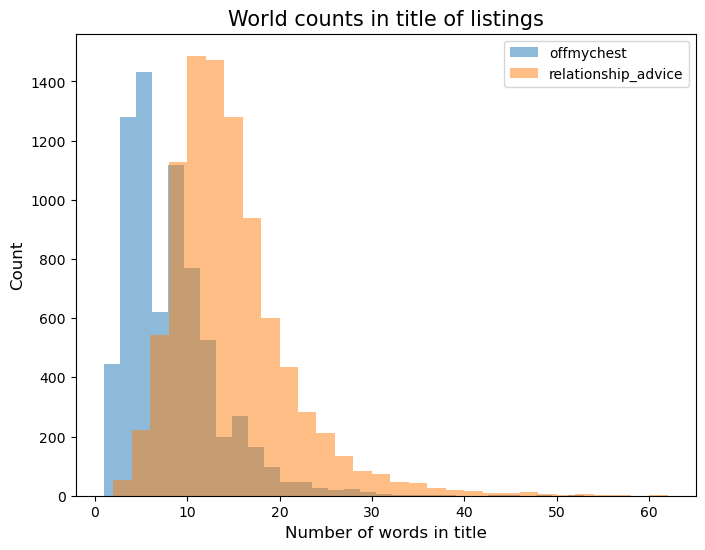

In [30]:
plt.figure(figsize=(8, 6))
plt.hist(df[df['subreddit'].str.contains('offmychest')]['count_title'], bins=30, alpha=0.5, label='offmychest')
plt.hist(df[df['subreddit'].str.contains('relationship_advice')]['count_title'], bins=30, alpha=0.5, label='relationship_advice')
plt.legend()
plt.xlabel('Number of words in title', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('World counts in title of listings', fontsize = 15);

The distribution graphs also show that the words count in both title and text of the postings in the relationship advice subreddit is more than that of the offmychest subreddit. This features can be used later to help categorize our listings. 

### Sentiment analysis of the text and comparing the scores
In this section, we will use sentiment analysis tools to evaluate the sentiment of the sentences and see if there is any relation between the sentiments and the subreddit.

In [122]:
# instantiate the sentiment analyzer
sent = SentimentIntensityAnalyzer()

In [123]:
# combine the title and text of the listing
# get a sentiment compound score
df['sentiment'] = df.apply(lambda x: 
                           sent.polarity_scores(x['text']+x['title'])['compound'],
                           axis=1)

In [124]:
df.head(1)

,text,title,listingid,created,url,subreddit,posting_hr,posting_day,count_text,count_title,sentiment
0,Sometimes I’m like oh wow can’t wait to marry ...,I am so up and down about my relationship.,18st4x1,1.703768e+09,https://www.reddit.com/r/offmychest/comments/1...,offmychest,12,3,104,8,0.856


In [125]:
df.groupby(['subreddit'], as_index=False).agg({'sentiment':['min', 'max','mean']})

subreddit sentiment                  
                             min     max      mean
0           offmychest   -0.9998  1.0000 -0.066194
1  relationship_advice   -1.0000  0.9999  0.310930

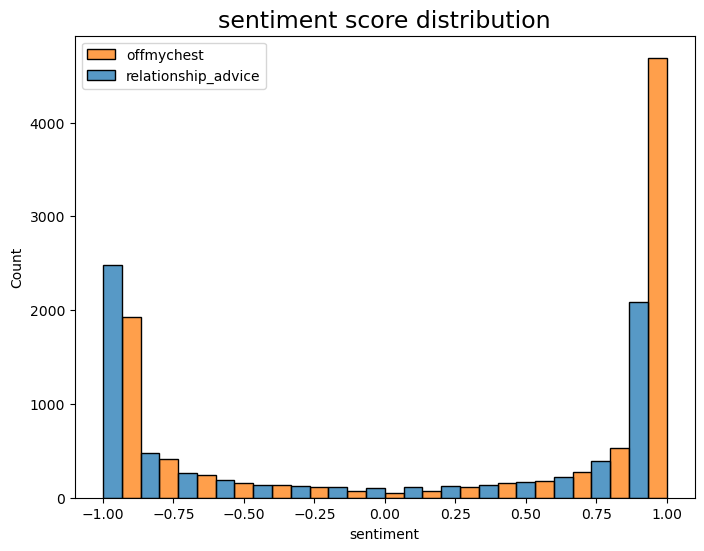

In [126]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='sentiment', hue='subreddit', multiple='dodge')
plt.legend(['offmychest', 'relationship_advice'])
plt.title('sentiment score distribution', size=17);

It is clear from the graph and also from the table that the sentiment of words in the relationship_advice subreddit is more towards the positive sentiment while that of the offmychest tends to be a mix of negative and positive side. Looking at the nature of the latter one, it was predictable to get such results. These sentiment scores could later be used in our classification algorithms. 

### Word analysis with CountVectorizer

In this section, we will try to analyze the words in each of the subreddit listings and see what sort of information can we extract from it. 

In [127]:
# let us first create a df with vectorized words
df['text_title'] = df.apply(lambda x: x['text'] + x['title'] ,axis=1)
df_vectorized = df['text_title']
df_vectorized.head(3)

0    Sometimes I’m like oh wow can’t wait to marry ...
1    \nMy girlfriend is bisexual. While I don’t hav...
2    My girlfriend and I have been together for ove...
Name: text_title, dtype: object

In [128]:
# create a countvectorizer object and use it to vectorize the column
cvec = CountVectorizer(stop_words='english')
# note that df_vectorized should not be a matrix or dataframe here, it 
# should be vector or a series
cvec.fit(df_vectorized)
df_vectorized = cvec.transform(df_vectorized)
# convert df_vetorized to dataframe with all new features
df_vectorized = pd.DataFrame(df_vectorized.todense(), 
                             columns=cvec.get_feature_names_out())
print(df_vectorized.shape)
df_vectorized.head(3)


(16261, 41209)


,00,000,000mi,000pesos,005,00am,00pm,01,0100,02,...,台北動物園,故宮博物院,牛肉飯,白房子,眼神,豬血,貓空,陽明山,魯肉飯,鹽酥雞
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
# let us create two extra dataframes based on subreddits as well
df_vec_offmychest = df_vectorized[df['subreddit'] == 'offmychest']
df_vec_relationship = df_vectorized[df['subreddit'] == 'relationship_advice']
print(df_vec_offmychest.shape)
print(df_vec_relationship.shape)

(7120, 41209)
(9141, 41209)


To begin with, we will start analyzing the words in both of the subreddits.

In [130]:
df_vectorized.sum().sort_values(ascending=False).head(20)

just            37550
like            34796
don             26050
know            23008
time            22454
feel            22022
want            20739
ve              19009
really          16589
said            15832
relationship    15547
told            14063
things          14036
didn            13651
years           12423
friends         12380
think           11603
got             11397
love            10651
going           10526
dtype: int64

Looking at this data, we can find words like 'feel', 'like', 'relationship', 'friends', 'family' occur more frequently and it makes sense to see these words more often in the context of the subreddits we are investigating. Let us be more specific and look at r/offmychest and r/relationship_advice separately and see if we can find any common popular words there.  

In [131]:
# 20 most popular words in offmychest subreddit
df_vec_offmychest.sum().sort_values(ascending=False).head(20)

just       15559
like       13139
don        10197
feel        8671
know        8559
time        7407
want        7096
ve          7053
really      5754
life        5284
people      5159
didn        4697
got         4557
think       4405
friends     4362
years       4320
things      4234
told        4053
said        3989
family      3801
dtype: int64

In [132]:
# 20 most popular words in relationship_advice subreddit
df_vec_relationship.sum().sort_values(ascending=False).head(20)

just            21991
like            21657
don             15853
time            15047
know            14449
want            13643
feel            13351
relationship    12706
ve              11956
said            11843
really          10835
told            10010
things           9802
didn             8954
years            8103
friends          8018
think            7198
love             7037
going            6882
got              6840
dtype: int64

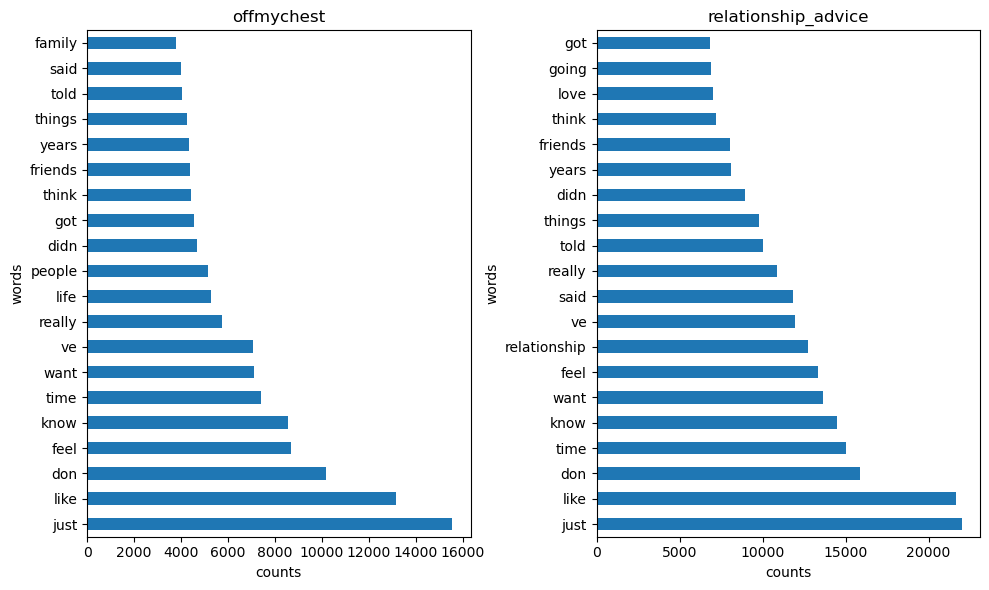

In [133]:
# let us plot the word counts side by side
fig, axs = plt.subplots(1, 2, figsize= (10,6))
df_vec_offmychest.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=axs[0])
axs[0].set_title('offmychest')
axs[0].set_xlabel('counts')
axs[0].set_ylabel('words')

df_vec_relationship.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=axs[1])
axs[1].set_title('relationship_advice')
axs[1].set_xlabel('counts')
axs[1].set_ylabel('words')

fig.tight_layout()

Looking at this graph, we can say there are some words that exist numerously in both of the subreddits, e.g. 'just', 'like', 'don', 'time', 'feel', etc. These words will not help us that much while using NLP to categorize listings, and most likely we can get rid of them during the tokenizing process by excluding the words that exist in large portions of our data. On the other hand, we can see words like 'life', 'people', 'family' that are amongst the most popular words in the offmychest subreddit but not in the relationship_advice. Words like 'relationship', 'love', 'told', 'said' are shown up in the most popular words of the relationship_advice subreddit but are not among that of offmychest.

To make these analysis more targeted, let us expand the popular words in each subreddit to 50 but remove the words that exist in both categories, as those words do not help us that much in separating the subreddits. 

In [134]:
ofmychest_topwords = df_vec_offmychest.sum().sort_values(ascending=False).head(80)
relationship_topwords = df_vec_relationship.sum().sort_values(ascending=False).head(80)
intersection_words = ofmychest_topwords.keys().intersection(relationship_topwords.keys())
len(intersection_words)

59

In [135]:
ofmychest_topwords = [[k, v] for k,v in ofmychest_topwords.items() if k not in intersection_words]
relationship_topwords = [[k, v] for k,v in relationship_topwords.items() if k not in intersection_words]

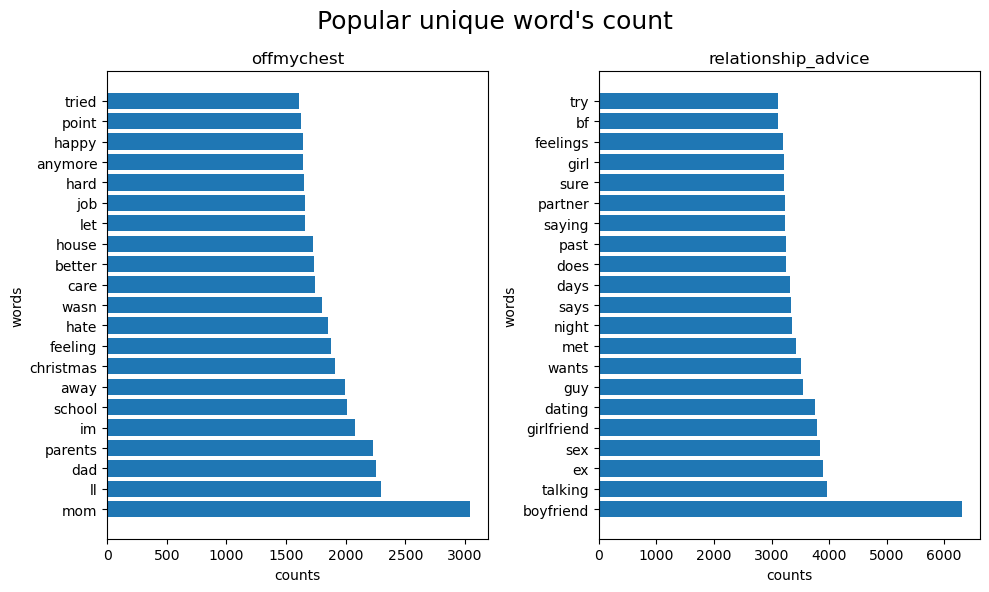

In [136]:
# let us plot the word counts side by side
fig, axs = plt.subplots(1, 2, figsize= (10,6))
fig.suptitle("Popular unique word's count", fontsize = 18)
axs[0].barh([el[0] for el in ofmychest_topwords], [el[1] for el in ofmychest_topwords])
axs[0].set_title('offmychest')
axs[0].set_xlabel('counts')
axs[0].set_ylabel('words')

axs[1].barh([el[0] for el in relationship_topwords], [el[1] for el in relationship_topwords])
axs[1].set_title('relationship_advice')
axs[1].set_xlabel('counts')
axs[1].set_ylabel('words')

fig.tight_layout()

These graphs give us a better idea of what are the popular words in each category that are unique to that category. We can see words like 'boyfriend', 'talking', 'sex', 'ex', 'girlfriend' in the relationship section while words like 'mom', 'dad', 'parents' in the offmychest subreddit. 

Now, let us do similar analysis but this time with bigrams (combination of two words instead of single words).

In [137]:
df_vectorized_bigram = df['text_title']
cvec_bigram = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=1000)
# note that max_features 1000 was used here as no limit for this would have caused some memory issues with bigrams. 
cvec_bigram.fit(df_vectorized_bigram)
df_vectorized_bigram = cvec_bigram.transform(df_vectorized_bigram)
# convert df_vetorized to dataframe with all new features
df_vectorized_bigram = pd.DataFrame(df_vectorized_bigram.todense(), 
                                    columns=cvec_bigram.get_feature_names_out())
df_vectorized_bigram.shape

(16261, 1000)

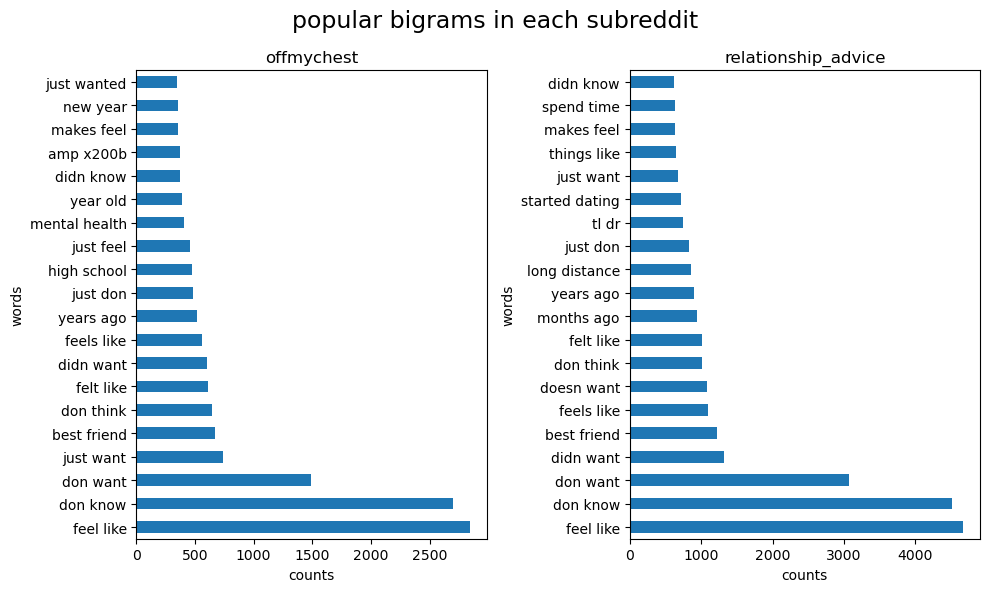

In [138]:
# let us create two extra dataframes based on subreddits as well
df_vec_offmychest_bigram = df_vectorized_bigram[df['subreddit'] == 'offmychest']
df_vec_relationship_bigram = df_vectorized_bigram[df['subreddit'] == 'relationship_advice']

# let us plot the word counts side by side
fig, axs = plt.subplots(1, 2, figsize= (10,6))
fig.suptitle('popular bigrams in each subreddit', fontsize = 17)
df_vec_offmychest_bigram.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=axs[0])
axs[0].set_title('offmychest')
axs[0].set_xlabel('counts')
axs[0].set_ylabel('words')

df_vec_relationship_bigram.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=axs[1])
axs[1].set_title('relationship_advice')
axs[1].set_xlabel('counts')
axs[1].set_ylabel('words')

fig.tight_layout()

Bigram analysis in this case does not add that much of information to us as a big portion of popular bigrams are terms like don't 'verb'. The interesting points are presence of words like 'mental health', 'best friend' in offmychest subreddit and words like 'long distance' and 'started dating' in relationship_advice subreddit. 

## Data preparation
Before concluding this section of the work, let us create a new .csv file with information we extracted from the raw data to use in our future analysis. We will prepare the data based on what we observed in the EDA and use the necessary information. 

In [139]:
# read the data from the .csv file created in the previous section
df = pd.read_csv('./../dataset/offmychestrelationship_advice.csv')

In [140]:
# drop unnecessary columns
df = df.drop(columns=['listingid', 'created', 'url', 'media'])
# mix text and title columns
df['text'] = df.apply(lambda x: x['text'] + x['title'], axis=1)
df = df.drop(columns=['title'])
# convert subreddit names to numbers offmychest = 0, relationship_advice = 1
df['subreddit'] = df['subreddit'].map({'offmychest': 0, 'relationship_advice': 1})
df.head(3)

,text,subreddit
0,Sometimes I’m like oh wow can’t wait to marry ...,0
1,\nMy girlfriend is bisexual. While I don’t hav...,1
2,My girlfriend and I have been together for ove...,1


In [142]:
# add a new column for the word count in the text
df['word_count'] = df['text'].apply(lambda x: len(re.findall(r'(?u)\b\w\w+\b', x)))
# add a new column for the sentiment of the text in each listing
sent = SentimentIntensityAnalyzer()
df['sentiment'] = df.apply(lambda x: 
                           sent.polarity_scores(x['text'])['compound'],
                           axis=1)
df.head(3)

# write data to .csv file

df.to_csv('./../dataset/offmychestrelationship_advice_processed.csv', index=False)

## Key takeaways
In this notebook, we prepared the scrapped data and performed exploratory data analysis. Here are the important points from this analysis:
- Although information like the time of the listing could potentially provide some insight for us, due to the short span of the data collection in this project, we don't believe that information provide any valuable insight for us.
- The number of the words used in each of the subreddits clearly differ and we will use that later for further analysis. 
- Our sentiment analysis shows that listing in the offmychest subreddit have a relatively higher positive sentiment. We will investigate it more later to see how it could affect our results.
- Detailed analysis of the popular words in each of the subreddits has helped us get a better idea of what words are seen more often in each of the subreddits. The words that exclusively exist in each of the subreddits give us valuable information on how we can classify the listings. 

**Based on the trends we have observed with the data, our guess is that the subreddits of interest exhibit enough deviation from each other so that we can classify the listings. The quality and accuracy of the classification problem will be determined in later notebooks**